# Setup

## Installing requirements and cloning repo

In [1]:
!pip install -q torch numpy transformers datasets tiktoken wandb tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.2/492.2 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 47.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 48.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.7/214.7 kB 25.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... do

In [2]:
!git clone https://github.com/johnowhitaker/nanoGPT_QuietAttention

Cloning into 'nanoGPT_QuietAttention'...
remote: Enumerating objects: 652, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 652 (delta 0), reused 0 (delta 0), pack-reused 649
Receiving objects: 100% (652/652), 941.78 KiB | 3.17 MiB/s, done.
Resolving deltas: 100% (373/373), done.


In [3]:
%cd nanoGPT_QuietAttention

/content/nanoGPT_QuietAttention


## Prepare the data

In [4]:
# Prepare the data
!python data/shakespeare_char/prepare.py

length of dataset in characters: 1,115,394
all the unique characters: 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
vocab size: 65
train has 1,003,854 tokens
val has 111,540 tokens


# Train a Baseline Model and a QuietAttention Version



## First, the Baseline

Nothing changed from Karpathy's version* - this is the baseline we will compare our model to.

* Except that I set it to use non-flash attention to make sure it really is just the single line change that's affecting results. You can add `use_flash = True` to the config for faster training once satisfied there is no funny business going on with the custom attention implementation.

In [7]:
# Train a quick model as a baseline
!python train.py config/train_shakespeare_char.py

Overriding config with config/train_shakespeare_char.py:
# train a miniature character-level shakespeare model
# good for debugging and playing on macbooks and such

out_dir = 'out-shakespeare-char'
eval_interval = 250 # keep frequent because we'll overfit
eval_iters = 200
log_interval = 10 # don't print too too often

# we expect to overfit on this small dataset, so only save when val improves
always_save_checkpoint = False

wandb_log = False # override via command line if you like
wandb_project = 'shakespeare-char'
wandb_run_name = 'mini-gpt'

dataset = 'shakespeare_char'
gradient_accumulation_steps = 1
batch_size = 64
block_size = 256 # context of up to 256 previous characters

# baby GPT model :)
n_layer = 6
n_head = 6
n_embd = 384
dropout = 0.2

learning_rate = 1e-3 # with baby networks can afford to go a bit higher
max_iters = 5000
lr_decay_iters = 5000 # make equal to max_iters usually
min_lr = 1e-4 # learning_rate / 10 usually
beta2 = 0.99 # make a bit bigger because number of 

## Now A Version with QuietAttention

In [8]:
%%writefile config/train_shakespeare_char_quiet.py
out_dir = 'out-shakespeare-char-quiet'
eval_interval = 250 # keep frequent because we'll overfit
eval_iters = 200
log_interval = 10 # don't print too too often

# we expect to overfit on this small dataset, so only save when val improves
always_save_checkpoint = False

wandb_log = False # override via command line if you like
wandb_project = 'shakespeare-char'
wandb_run_name = 'mini-gpt'

dataset = 'shakespeare_char'
gradient_accumulation_steps = 1
batch_size = 64
block_size = 256 # context of up to 256 previous characters

# baby GPT model :)
n_layer = 6
n_head = 6
n_embd = 384
dropout = 0.2

learning_rate = 1e-3 # with baby networks can afford to go a bit higher
max_iters = 5000
lr_decay_iters = 5000 # make equal to max_iters usually
min_lr = 1e-4 # learning_rate / 10 usually
beta2 = 0.99 # make a bit bigger because number of tokens per iter is small

warmup_iters = 100 # not super necessary potentially

# Now the new stuff:
quiet = True

Writing config/train_shakespeare_char_quiet.py


In [9]:
# Train a model with this new configuration:
!python train.py config/train_shakespeare_char_quiet.py

Overriding config with config/train_shakespeare_char_quiet.py:
out_dir = 'out-shakespeare-char-quiet'
eval_interval = 250 # keep frequent because we'll overfit
eval_iters = 200
log_interval = 10 # don't print too too often

# we expect to overfit on this small dataset, so only save when val improves
always_save_checkpoint = False

wandb_log = False # override via command line if you like
wandb_project = 'shakespeare-char'
wandb_run_name = 'mini-gpt'

dataset = 'shakespeare_char'
gradient_accumulation_steps = 1
batch_size = 64
block_size = 256 # context of up to 256 previous characters

# baby GPT model :)
n_layer = 6
n_head = 6
n_embd = 384
dropout = 0.2

learning_rate = 1e-3 # with baby networks can afford to go a bit higher
max_iters = 5000
lr_decay_iters = 5000 # make equal to max_iters usually
min_lr = 1e-4 # learning_rate / 10 usually
beta2 = 0.99 # make a bit bigger because number of tokens per iter is small

warmup_iters = 100 # not super necessary potentially

# Now the new stu

# Sampling from the models

A good sanity check to see if they're roughly equally garbled:

In [10]:
!python sample.py --out_dir=out-shakespeare-char --num_samples=1

Overriding: out_dir = out-shakespeare-char
Overriding: num_samples = 1
number of parameters: 10.65M
Loading meta from data/shakespeare_char/meta.pkl...


Clown:
So in one faults are to a serious blood,
That the day hath been the purpose of blood?

Shepherd:
How cannot accept me talk to the way
Before the world estimation! come alive,
Too base and to present that will lind the law,
Which with stars as she would lose up or double
To see thy world that more not when evils,
Than thou wilt never show more were to her brants,
Than so reary to she will fled at thee arms,
Which, as I seem should say as a man in her
By the strange of one honour.

BENVOLI
---------------


In [11]:
!python sample.py --out_dir=out-shakespeare-char-quiet --num_samples=1

Overriding: out_dir = out-shakespeare-char-quiet
Overriding: num_samples = 1
number of parameters: 10.65M
Loading meta from data/shakespeare_char/meta.pkl...


Clown:
So you will kiss you that you have done with a mother
taunt: 'tis a purpose to be to laugh.

AUTOLYCUS:
Has you not the one of this?

Clown:
What, it is your majesty, ladies, and by your highness
of your own plantage of the market-blood,
that she would lose us or does it?

Shepherd:
A mother, only so doth evil so, and so rise
A guilty stooping should hear him not speak.

AUTOLYCUS:
Not your poor fishes.

Clown:
Nor I; I know, I did but say your grace.

Shepherd:
A very rests I command.


---------------


# Loading the model and getting activations

In [19]:
from matplotlib import pyplot as plt

In [15]:
#@title code from the sampling script
import os
import pickle
from contextlib import nullcontext
import torch
import tiktoken
from model import GPTConfig, GPT

# -----------------------------------------------------------------------------
init_from = 'resume' # either 'resume' (from an out_dir) or a gpt2 variant (e.g. 'gpt2-xl')
start = "\n" # or "<|endoftext|>" or etc. Can also specify a file, use as: "FILE:prompt.txt"
num_samples = 1 # number of samples to draw
max_new_tokens = 500 # number of tokens generated in each sample
temperature = 0.8 # 1.0 = no change, < 1.0 = less random, > 1.0 = more random, in predictions
top_k = 200 # retain only the top_k most likely tokens, clamp others to have 0 probability
seed = 1337
device = 'cuda' # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1', etc.
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32' or 'bfloat16' or 'float16'
compile = False # use PyTorch 2.0 to compile the model to be faster
# --

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)


def load_model(out_dir):

  # model
  if init_from == 'resume':
      # init from a model saved in a specific directory
      ckpt_path = os.path.join(out_dir, 'ckpt.pt')
      checkpoint = torch.load(ckpt_path, map_location=device)
      gptconf = GPTConfig(**checkpoint['model_args'])
      model = GPT(gptconf)
      state_dict = checkpoint['model']
      unwanted_prefix = '_orig_mod.'
      for k,v in list(state_dict.items()):
          if k.startswith(unwanted_prefix):
              state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
      model.load_state_dict(state_dict)
  elif init_from.startswith('gpt2'):
      # init from a given GPT-2 model
      model = GPT.from_pretrained(init_from, dict(dropout=0.0))

  model.eval()
  model.to(device)

  # look for the meta pickle in case it is available in the dataset folder
  load_meta = False
  if init_from == 'resume' and 'config' in checkpoint and 'dataset' in checkpoint['config']: # older checkpoints might not have these...
      meta_path = os.path.join('data', checkpoint['config']['dataset'], 'meta.pkl')
      load_meta = os.path.exists(meta_path)
  if load_meta:
      print(f"Loading meta from {meta_path}...")
      with open(meta_path, 'rb') as f:
          meta = pickle.load(f)
      # TODO want to make this more general to arbitrary encoder/decoder schemes
      stoi, itos = meta['stoi'], meta['itos']
      encode = lambda s: [stoi[c] for c in s]
      decode = lambda l: ''.join([itos[i] for i in l])
  else:
      # ok let's assume gpt-2 encodings by default
      print("No meta.pkl found, assuming GPT-2 encodings...")
      enc = tiktoken.get_encoding("gpt2")
      encode = lambda s: enc.encode(s, allowed_special={"<|endoftext|>"})
      decode = lambda l: enc.decode(l)

  return model, encode, decode

Here we load the baseline model and sample some text, but now we have the output activations stored via a hook function so we can inspect them at our leisure:

In [18]:
# Load the baseline model
model, encode, decode = load_model('out-shakespeare-char')

# Hook function to store outputs in a .output attribute
def hook_fn(module, input, output):
    module.output = output

# Register with all the blocks' MLPs
for b in model.transformer.h:
  b.mlp.register_forward_hook(hook_fn);

# encode the beginning of the prompt
start = 'CLOWN:'
start_ids = encode(start)
x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])

# run generation
with torch.no_grad():
    with ctx:
        for k in range(num_samples):
            y = model.generate(x, max_new_tokens, temperature=temperature, top_k=top_k)
            print(decode(y[0].tolist()))
            print('---------------')

number of parameters: 10.65M
Loading meta from data/shakespeare_char/meta.pkl...
CLOWN:
Misery, knees, my soul shame hath no more foot of four self--
Where he shall be the world?

DUKE OF AUMERLE:
So that lords and so that work.

LORD STANLEY:
I told thee the souls of your time:
He doth be fearful so that Claudio,
And thou loved me, more than the babes;
That he is wrong'd with your lambs of course.

Lord Marshal:
So, he did do but brother, for they see thee ill.

DUKE OF AUMERLE:
No matter, I will. What will not this most man carried
For this matter, thus would have more than the 
---------------


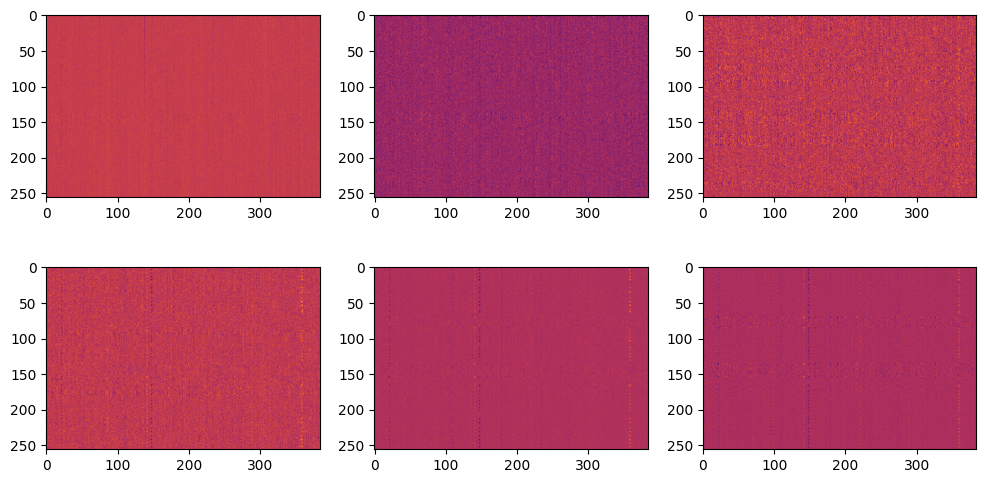

In [25]:
outputs = [b.mlp.output for b in model.transformer.h]
fig, axs = plt.subplots(2, 3, figsize=(12, 6))
for ax, o in zip(axs.flatten(), outputs):
  ax.imshow(o.cpu()[0], cmap='inferno')

We can do the same for the QuietAttention version:

number of parameters: 10.65M
Loading meta from data/shakespeare_char/meta.pkl...


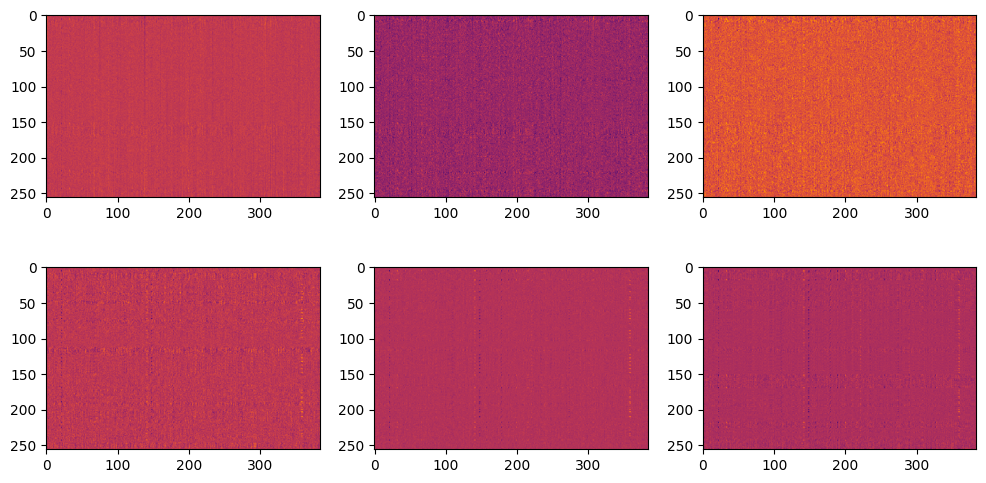

In [26]:
# Load the baseline model
model, encode, decode = load_model('out-shakespeare-char-quiet')

# Hook function to store outputs in a .output attribute
def hook_fn(module, input, output):
    module.output = output

# Register with all the blocks' MLPs
for b in model.transformer.h:
  b.mlp.register_forward_hook(hook_fn);

# encode the beginning of the prompt
start = 'CLOWN:'
start_ids = encode(start)
x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])

# run generation
with torch.no_grad():
    with ctx:
      y = model.generate(x, max_new_tokens, temperature=temperature, top_k=top_k)

quiet_outputs = [b.mlp.output for b in model.transformer.h]
fig, axs = plt.subplots(2, 3, figsize=(12, 6))
for ax, o in zip(axs.flatten(), quiet_outputs):
  ax.imshow(o.cpu()[0], cmap='inferno')


Text(0.5, 1.0, 'Activation distribution, final block MLP, QuietAttention')

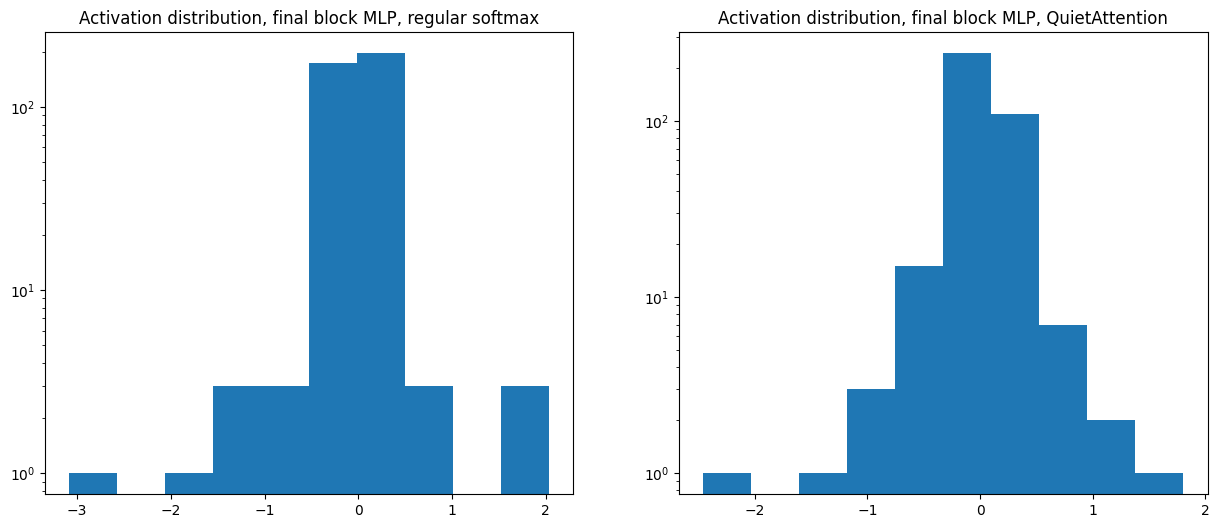

In [28]:
# Compare the distributions for the final output activations
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
axs[0].hist(outputs[-1][0].mean(dim=0).cpu(), log=True)
axs[0].set_title("Activation distribution, final block MLP, regular softmax")
axs[1].hist(quiet_outputs[-1][0].mean(dim=0).cpu(), log=True)
axs[1].set_title("Activation distribution, final block MLP, QuietAttention")